In [1]:
%%bash
hostname

brewer


In [2]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import seaborn as sns
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from mpl_toolkits.basemap import Basemap

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn as nn

import matplotlib.animation as animation

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

# Train quick ridge regression model on ATom data

In [4]:
atom1_data_with_p = pd.read_csv('/home/shmh4/Downloads/atom1_key_species_photolysis_data_withP_T_G_ALT')

In [5]:
atom1_key_data = atom1_data_with_p[['OH_ATHOS', 'H2O_DLH', 'CH4_NOAA', 'CO_NOAA', 'NO2_CL', 'O3_CL', 'P', 
                                    'T', 'jO3_O2_O1D_CAFS', 'jNO2_NO_O3P_CAFS']]

In [6]:
atom1_key_data

,OH_ATHOS,H2O_DLH,CH4_NOAA,CO_NOAA,NO2_CL,O3_CL,P,T,jO3_O2_O1D_CAFS,jNO2_NO_O3P_CAFS
0,0.033,14481.3750,1857.670,65.6200,0.137210,14.1900,971.060,286.10,0.000004,0.001899
1,0.033,14469.1625,1858.330,69.1800,0.135045,14.1430,971.300,286.35,0.000004,0.001897
2,0.033,14456.9500,1858.990,72.7400,0.132880,14.0960,971.540,286.60,0.000004,0.001896
3,0.033,14486.2550,1859.175,71.8075,0.126100,14.1320,971.830,286.60,0.000004,0.001894
4,0.033,14515.5600,1859.360,70.8750,0.119320,14.1680,972.120,286.60,0.000004,0.001892
...,...,...,...,...,...,...,...,...,...,...
221412,0.156,21538.2300,1888.280,97.9800,0.105910,21.7190,996.180,298.51,0.000023,0.008666
221413,0.156,21493.8600,1888.900,95.6700,0.119190,21.7725,996.320,298.61,0.000023,0.008669
221414,0.156,21449.4900,1889.520,93.3600,0.132470,21.8260,996.460,298.71,0.000023,0.008672
221415,0.156,21385.1550,1890.125,101.9450,0.170770,21.8350,996.605,298.77,0.000023,0.008690


In [7]:
### Calculate OH mean and standard deviation for use later.

In [8]:
OH_mean = atom1_key_data.mean()[0]
OH_mean

0.18708638903062094

In [9]:
OH_std = atom1_key_data.std()[0]
OH_std

0.22123271214725962

In [10]:
### Normalise the dataset

In [11]:
normalised_key_atom1_data = (atom1_key_data - atom1_key_data.mean()) / atom1_key_data.std()

In [12]:
normalised_key_atom1_data

,OH_ATHOS,H2O_DLH,CH4_NOAA,CO_NOAA,NO2_CL,O3_CL,P,T,jO3_O2_O1D_CAFS,jNO2_NO_O3P_CAFS
0,-0.696490,1.861055,0.821655,-0.432718,1.606353,-1.157352,1.863852,1.370637,-0.875211,-1.114259
1,-0.696490,1.859035,0.842557,-0.306461,1.574038,-1.158623,1.864758,1.379210,-0.875210,-1.114532
2,-0.696490,1.857015,0.863459,-0.180205,1.541723,-1.159895,1.865665,1.387783,-0.875209,-1.114806
3,-0.696490,1.861862,0.869318,-0.213276,1.440525,-1.158921,1.866760,1.387783,-0.875208,-1.115079
4,-0.696490,1.866709,0.875177,-0.246348,1.339327,-1.157947,1.867854,1.387783,-0.875207,-1.115353
...,...,...,...,...,...,...,...,...,...,...
221412,-0.140514,3.028325,1.791067,0.714938,1.139170,-0.953670,1.958696,1.796194,-0.060391,0.071606
221413,-0.140514,3.020985,1.810703,0.633013,1.337387,-0.952222,1.959225,1.799623,-0.060284,0.072176
221414,-0.140514,3.013646,1.830338,0.551088,1.535604,-0.950775,1.959753,1.803052,-0.060177,0.072746
221415,-0.140514,3.003005,1.849498,0.855557,2.107269,-0.950532,1.960301,1.805110,-0.059221,0.075965


In [13]:
### Split data into training and testing data manually

In [14]:
train_OH_ATHOS = normalised_key_atom1_data.iloc[np.r_[185000:188285, 195485:221417], 0]
test_OH_ATHOS = normalised_key_atom1_data.iloc[188285:195485, 0]
train_data = normalised_key_atom1_data.iloc[np.r_[185000:188285, 195485:221417], 1:11]
test_data = normalised_key_atom1_data.iloc[188285:195485, 1:11]

In [15]:
### Split data using k-fold 

In [16]:
OH_data = normalised_key_atom1_data.iloc[185000:221417, 0]
other_data = normalised_key_atom1_data.iloc[185000:221417, 1:11]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(other_data, OH_data, test_size=0.4, random_state=0)

In [18]:
rr = Ridge(alpha=1e-2, fit_intercept=False)
rr.fit(X_train,y_train)

Ridge(alpha=0.01, fit_intercept=False)

In [19]:
rr.get_params()

{'alpha': 0.01,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [20]:
rr.coef_

array([ 0.25108994,  0.31849412,  0.16192909,  0.37956047,  0.0609911 ,
       -0.4915139 , -0.24515337,  0.19122984,  0.9351133 ])

In [21]:
predictions = rr.predict(X_test)

(-2.0, 9.0)

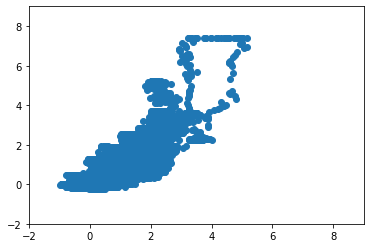

In [22]:
plt.scatter(predictions, y_test)
plt.xlim([-2, 9])
plt.ylim([-2, 9])

(5000.0, 5100.0)

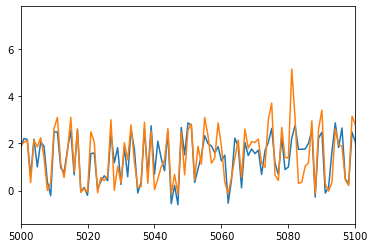

In [23]:
plt.plot(predictions)
plt.plot(np.arange(0,14567,1), y_test)
plt.xlim(5000,5100)

# Plot coefficients of the RR model

In [24]:
coefs = pd.DataFrame(rr.coef_, columns=['Coefficients'], index = normalised_key_atom1_data.columns[1:10])

In [25]:
coefs

,Coefficients
H2O_DLH,0.251090
CH4_NOAA,0.318494
CO_NOAA,0.161929
NO2_CL,0.379560
O3_CL,0.060991
P,-0.491514
T,-0.245153
jO3_O2_O1D_CAFS,0.191230
jNO2_NO_O3P_CAFS,0.935113


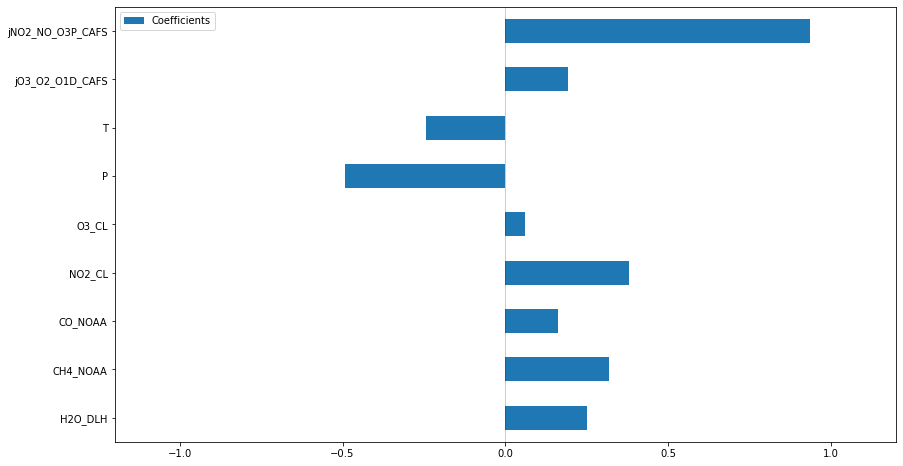

In [26]:
coefs.plot(kind='barh', figsize=(14, 8))
plt.xlim(-1.2, 1.2)
plt.axvline(x=0, color = 'k', alpha = 0.2, linewidth = 1)


# Check coefficients are legitimate with k fold cross validation

In [27]:
cv_results = cross_validate(rr, other_data, OH_data, cv=RepeatedKFold(n_splits=10, n_repeats=1),
    return_estimator=True, n_jobs=-1)

In [28]:
empty_list = []

In [29]:
for model in cv_results['estimator']:
    empty_list.append(model.coef_)

In [30]:
df_coefs = pd.DataFrame(empty_list) 

In [31]:
df_coefs.columns = [normalised_key_atom1_data.columns[1:10]]

In [32]:
df_coefs.transpose()

,0,1,2,3,4,5,6,7,8,9
H2O_DLH,0.263232,0.261376,0.262263,0.261300,0.260199,0.259478,0.263523,0.265849,0.260259,0.261320
CH4_NOAA,0.315068,0.315929,0.316495,0.322123,0.309788,0.316887,0.314646,0.312600,0.317520,0.316217
CO_NOAA,0.158856,0.161654,0.160858,0.154937,0.163329,0.161777,0.158855,0.154640,0.156545,0.162239
NO2_CL,0.397285,0.395908,0.395281,0.393287,0.397073,0.391261,0.393695,0.397946,0.392921,0.394519
O3_CL,0.067293,0.066796,0.069832,0.071693,0.073080,0.075628,0.068576,0.071332,0.071170,0.072781
P,-0.536116,-0.541999,-0.530658,-0.532016,-0.514566,-0.521924,-0.537497,-0.543126,-0.530950,-0.535222
T,-0.203419,-0.196936,-0.209134,-0.208759,-0.219907,-0.211580,-0.203887,-0.197615,-0.205762,-0.200174
jO3_O2_O1D_CAFS,0.181489,0.177071,0.180689,0.187695,0.187004,0.177308,0.188203,0.189106,0.183280,0.182630
jNO2_NO_O3P_CAFS,0.926302,0.932789,0.927667,0.911297,0.933974,0.938052,0.918309,0.917305,0.928163,0.925789


/home/shmh4/.conda/envs/netcdf/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Coefficient importance and its variability')

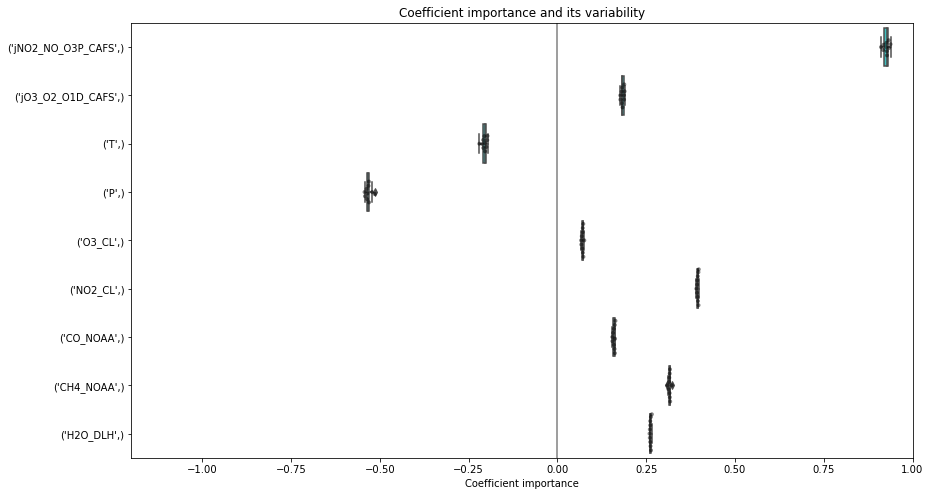

In [33]:
plt.figure(figsize=(14, 8))
sns.swarmplot(data=df_coefs, orient='h', color='k', alpha=0.5, size = 4)
sns.boxplot(data=df_coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.gca().invert_yaxis()
plt.xlim(-1.2, 1,2)
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')


In [34]:
# ppm to concentration transformation function

In [35]:
def M(p, T):
    m = p*100 / (1.38065e-23 * T)
    return m/1000000

In [36]:
m_atmos = M(X_test['P'], X_test['T'])

In [37]:
X_test.index

Int64Index([213809, 219755, 219569, 212406, 213532, 194184, 202008, 205996,
            185759, 192812,
            ...
            206140, 210522, 201948, 210893, 220402, 206081, 206157, 202241,
            218929, 193585],
           dtype='int64', length=14567)

# Train quick neural net on ATom data

In [38]:
train_features = torch.tensor(X_train.values)
test_features = torch.tensor(X_test.values)
train_labels = torch.tensor(y_train.values).reshape(-1,1)
test_labels = torch.tensor(y_test.values).reshape(-1,1)

In [39]:
train_features, train_labels = Variable(train_features), Variable(train_labels)

In [40]:
class ModernAffineLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_probs=0.3):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout_probs)

    def forward(self, x, final=False):
        x = self.linear(x)

        if not final:
            x = self.activation(x)
            x = self.dropout(x)

        x = self.bn(x)
        return x

In [41]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ModernAffineLayer(9, 256) # this is a block
        self.layer2 = ModernAffineLayer(256, 128)
        self.layer3 = ModernAffineLayer(128, 128)
        self.layer4 = ModernAffineLayer(128, 16)
        self.layer5 = ModernAffineLayer(16, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x, final=True)
        mean = x
        return mean

In [42]:
model = Model()

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay = 1e-13)
loss_func = torch.nn.MSELoss()

batch_size = 128
EPOCH = 25

In [44]:
torch_dataset = Data.TensorDataset(train_features, train_labels)

In [45]:
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size,
    shuffle=True, num_workers=2,)

In [46]:
def train_step(data, label):
    data = Variable(data).float()
    label = Variable(label).float()

    mean = model(data)
    loss = loss_func(mean, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.data

In [47]:
def train_epoch():
    for step, (data,label) in enumerate(loader):
        last_loss = train_step(data, label)
    return last_loss

In [ ]:
for epoch in range(EPOCH):
    last_loss = train_epoch()
    print(f'Epoch: {epoch+1}, Loss: {last_loss}')

Epoch: 1, Loss: 2.0594661235809326
Epoch: 2, Loss: 1.593840479850769
Epoch: 3, Loss: 1.4835076332092285
Epoch: 4, Loss: 1.604374885559082
Epoch: 5, Loss: 1.6609110832214355
Epoch: 6, Loss: 1.2597886323928833
Epoch: 7, Loss: 1.6652804613113403


In [ ]:
net_applied_to_training_data = model(train_features.float()).detach().numpy()
net_applied_to_testing_data = model(test_features.float()).detach().numpy()

In [ ]:
for _ in range(19):
    net_applied_to_testing_data_temp = model(test_features.float()).detach().numpy()
    net_applied_to_testing_data = np.concatenate((net_applied_to_testing_data, net_applied_to_testing_data_temp), axis=1)

In [ ]:
mean_prediction = net_applied_to_testing_data.mean(axis=1)
var_prediction = net_applied_to_testing_data.var(axis=1)

In [ ]:
plt.figure(dpi=100)
plt.plot(mean_prediction)
#plt.fill_between(range(77676), all_net_outputs_mean - 25*all_net_outputs_var, all_net_outputs_mean + 25*all_net_outputs_var, alpha=0.2, color="b")
plt.plot(test_labels, color='r')
#plt.xlim(2000,2200)

In [ ]:
fig, ax1 = plt.subplots(dpi=500)

ax1.plot(range(14567), ((mean_prediction*OH_std) + OH_mean) * m_atmos * 1e-12, label = 'NN [OH]')
ax1.fill_between(range(14567), ((mean_prediction - np.sqrt(var_prediction))*OH_std + OH_mean)*m_atmos*1e-12, ((mean_prediction + np.sqrt(var_prediction))*OH_std + OH_mean)*m_atmos*1e-12, alpha=0.2, color="b", label='Uncertainty in NN')
ax1.plot(range(14567), ((y_test*OH_std) + OH_mean) * m_atmos * 1e-12, color='r', label='Observed [OH]')

#myFmt = mdates.DateFormatter('%H:%M')
#ax1.xaxis.set_major_formatter(myFmt)

ax1.set_ylabel('[OH] / molecules cm-3')
ax1.set_xlabel('Time')
ax1.legend(fontsize=6)
ax1.set_title('Neural network model', fontsize=10)
plt.ylim(-0.1e9, 1.45e8)
plt.xlim(2000,2600)